In [1]:
import numpy as np
import pandas as pd
import scipy
import multiprocessing
import matplotlib.pyplot as plt
import os
import subprocess
from tqdm import tqdm

Constants and functions for generating and computing NEOMOD3 orbits and their impact probabilities:

In [2]:
# constants for earth and sun
a0 = 1.  # semi-major axis of earth in au
m = 5.97e24  # mass of earth in kg
R = 4.259e-5  # radius of earth in au
M = 1.988e30  # mass of sun in kg
e0 = 0.# 01671123  # eccentricitiy of earth

compiler = 'gfortran'  # name of fortran compiler to use
# compile fortran code if it hasn't been already
subprocess.run([compiler, './Pokorny_et_al_2013/PROB_KOZAI_V001.f90', '-o', './Pokorny_et_al_2013/CODE', '-O3'])

# OPIK PROBABILITY PER REVOLUTION
def get_opik_annual_P_packed(aei, a0=a0, m=m, R=R, M=M):
    """
    Get the collision probability per revolution P for an object with semi-major axis a in AU, eccentricity e, and inclination i in degrees
    and a target (Earth) on a circular orbit with constant semi-major axis a0 in AU, mass m in kg, and radius R in AU, 
    both orbiting a star with mass M in kg

    return: P, the collision probability per revolution
    """
    a, e, i = aei
    Q = R/a0  # Q
    Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
    U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U
    tau = Q * np.sqrt(1 + ((2 * m)/(M * Q * (U ** 2))))  # tau
    # tau = R * np.sqrt(1 + R/Q)
    # compute P
    P = ((tau ** 2) * U)/(np.pi * np.sin(np.deg2rad(i)) * np.abs(Ux))
    # return
    return P


# define function
def get_pokorny_annual_P_packed(aeiperi, a_earth=a0, e_earth=e0, R_earth=R):
    """
    Get the collisional probability using Petr Pokorny's 2013 code with a, e, i, peri packed as a tuple
    Takes in a given a, e, i and argument of pericenter of the projectile and returns the annual collisional probability

    a is in units of AU, i is in units of degrees, argument of pericenter is in degrees
    """
    a, e, i, peri = aeiperi  # unpack
    # run fortran code
    output = subprocess.run(['./Pokorny_et_al_2013/CODE', '<'], 
                            input=f'{a},{e},{i},{peri}\n{a_earth}\n{e_earth}'.encode('utf-8'), 
                            capture_output=True)
    # print(output)
    col_prob = np.float64(output.stdout.decode('utf-8').split()[-1]) * (R_earth ** 2)
    return col_prob

# compile the NEOMOD3 model
neomod3_filename = './NEOMOD3_CODE'
# compile neomod3 fortran code
subprocess.run([compiler, './neomod3_simulator.f', '-o', neomod3_filename, '-O3'])

# generate debiased steady-state orbital distribution for both
size_min = 0.0079  # minimum size NEOMOD 3, km
size_max = 0.016  # maximum size NEOMOD 3, km
n_objs = 10000  # number of objects to generate
seed = -50202002  # seed to use

Generate NEOMOD3 objects:

In [3]:
# generate neomod3 output:
# Returns H, a (AU), e, i (degrees), diameter (km), albedo
neomod3_output = np.array(subprocess.run([neomod3_filename, '<'], 
                                input=f'input_neomod3.dat\n{seed}\n{n_objs}\n{size_min} {size_max}'.encode('utf-8'), 
                                capture_output=True).stdout.decode('utf-8').split(), dtype=np.float64).reshape(n_objs, 6)  # 6 parameters

# unpack values
neomod3_hs, neomod3_as, neomod3_es, neomod3_is, neomod3_sizes, neomod3_albs = neomod3_output.T

Compute the arguments of pericenter of each one required to make its orbit intersect that of a circular Earth with $a = 1$ AU:

In [4]:
def peri_intersect(a, e, r_t=a0):
    """
    Computes the two possible arguments of pericenter required for an object with a given a, e to 
    intersect the orbit of a planet on a circular orbit with semi-major axis r_t and randomly picks one.
    Returns argument of pericenter in degrees
    """
    # compute base case
    base = np.arccos((a * (1. - e ** 2) - r_t)/(e * r_t))
    # other case is offset by 180 degrees, randomly pick one of them and convert to degrees
    return np.rad2deg(np.c_[0. - base, np.pi - base][np.arange(len(base)), np.random.randint(0, 2, size=len(base))])

neomod3_peris = peri_intersect(neomod3_as, neomod3_es)

/tmp/ipykernel_250578/2197404127.py:8: RuntimeWarning: invalid value encountered in arccos
  base = np.arccos((a * (1. - e ** 2) - r_t)/(e * r_t))


In [5]:
neomod3_as.shape

(10000,)

Plot distribution of $\omega$ required to intersect Earth's orbit:

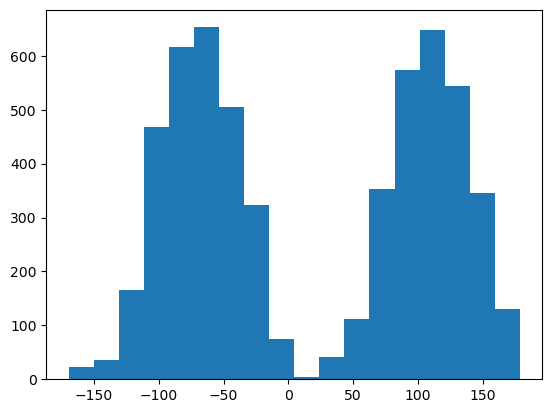

In [6]:
plt.hist(neomod3_peris, bins='auto')
plt.show()

Compute impact probability using Opik/Pokorny formalism:

In [7]:
# compute impact probabilities:
neomod3_aeis = np.c_[neomod3_as, neomod3_es, neomod3_is]
neomod3_aeiperis = np.c_[neomod3_as, neomod3_es, neomod3_is, neomod3_peris]
# multiprocess, computing for neomod2 and 3
pool = multiprocessing.Pool()
# neomod3_pts_pokorny = np.array(list(tqdm(pool.imap(get_pokorny_annual_P_packed, neomod3_aeiperis), total = len(neomod3_aeiperis))))
neomod3_pts = np.array(list(tqdm(pool.imap(get_opik_annual_P_packed, neomod3_aeis), total = len(neomod3_aeis))))
# join and close
pool.close()
pool.join()

  0%|                                                                                                                                                                                      | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_250578/4177065786.py:23: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_250578/4177065786.py:23: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_250578/4177065786.py:23: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_250578/4177065786.py:23: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_250578/4177065786.py:23: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_250578/4177065786.py:23: RuntimeWarning: invali

Truncate them at $f_\mathrm{imp} = 5\times 10^{-8}$ yr$^{-1}$, remove $0$ and nan values and remove objects that do not cross Earth's orbit (Atens/Amors). Here we assume Earth's orbit is a perfect circle with radius $1$ AU:

In [8]:
def filter_obj_mask(pts, qs, Qs, ip_threshold=5.e-8, target_a = 1.):
    """
    Return mask to truncate objects at ip threshold ip_threshold, remove 0 and nan values, 
    and remove objects that do not cross trarget's orbit
    """
    # mask
    return (0. < pts) & (pts < ip_threshold) & ~np.isnan(pts) & (qs < target_a) & (Qs > target_a)


neomod3_qs = neomod3_as * (1. - neomod3_es)
neomod3_Qs = neomod3_as * (1. + neomod3_es)
# mask for 0, nan, impact probability, q and Q
mask = filter_obj_mask(neomod3_pts, neomod3_qs, neomod3_Qs)
# apply to pts and qs
m_neomod3_pts = neomod3_pts[mask]
m_neomod3_qs = neomod3_qs[mask]

Plot $f_\mathrm{imp}$ against $q$:

(Text(0.5, 0, 'Annual impact probability'), Text(0, 0.5, 'q (AU)'))

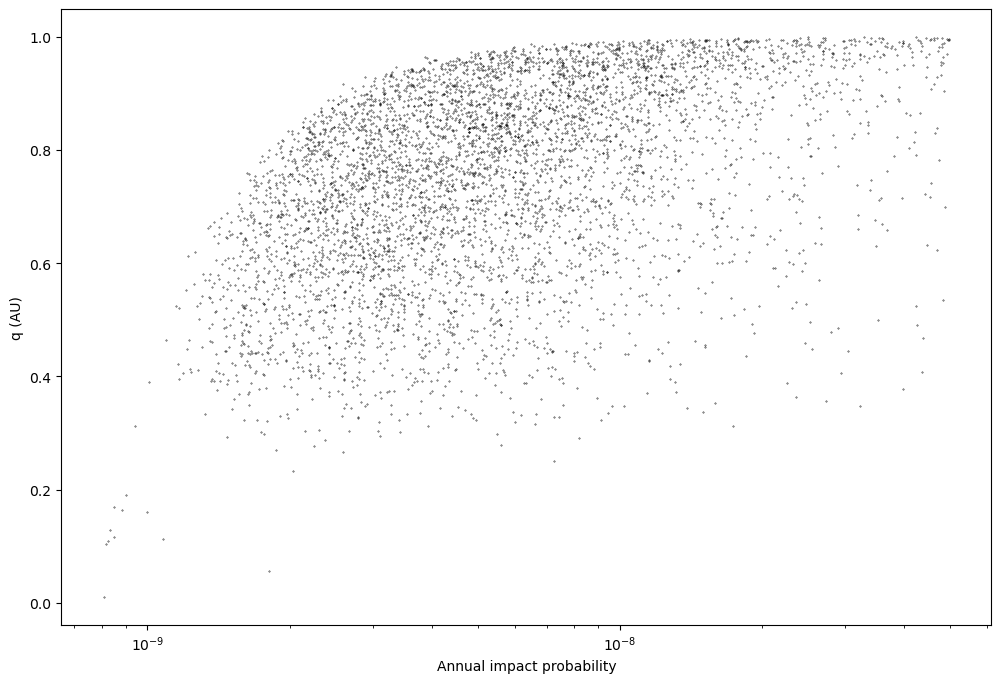

In [9]:
plt.figure(figsize = (12, 8))
plt.scatter(m_neomod3_pts, m_neomod3_qs, s=0.1, c='k')
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q (AU)')

Now assume each filtered object's argument of pericenter is aligned in such a way that it collides with Earth, and compute the Cartesian velocity vectors of the object and the Earth at the intersection of their orbit: 

In [23]:
from kep2cart import orbital_elements_to_cart_helio  # import this using code from Paul's course

# code to compute true anomaly as intersection point
def compute_intersection_for_circular_planet(a_a, e_a, i_a, omega_a, Omega_a):
    # Convert angles from degrees to radians
    omega_a, Omega_a = map(np.radians, [omega_a, Omega_a])

    # Solve for the true anomaly of the asteroid at intersection
    def true_anomaly_asteroid(a_a, e_a):
        cos_nu_a = (a_a * (1 - e_a**2) - 1) / e_a
        if abs(cos_nu_a) > 1:
            raise ValueError("No real intersection: the asteroid does not reach the planet's radius.")
        nu_a1 = np.arccos(cos_nu_a)  # First solution
        nu_a2 = -nu_a1  # Second solution
        return nu_a1, nu_a2

    # Compute the asteroid's true anomalies at intersection
    nu_a1, nu_a2 = true_anomaly_asteroid(a_a, e_a)

    # Compute the planet's true anomalies at the same positions
    nu_p1 = (Omega_a + nu_a1 - omega_a) % (2 * np.pi)
    nu_p2 = (Omega_a + nu_a2 - omega_a) % (2 * np.pi)

    # Convert to degrees for output
    return nu_p1, nu_p2, nu_a1, nu_a2

Constants and data:

In [24]:
rho = 1500.  # assume 1500 kg/m^3
G = 6.674e-11  # SI units

m_neomod3_output = neomod3_output[mask]  # filter neomod3 output
m_neomod3_hs, m_neomod3_as, m_neomod3_es, m_neomod3_is, m_neomod3_sizes, m_neomod3_albs = m_neomod3_output.T
m_neomod3_peris = neomod3_peris[mask]

m_neomod3_masses = 4. * rho * (m_neomod3_sizes * 1000./2.) ** 3  # convert size to m, rho is in kg/m^3 so mass is in kg
m_neomod3_masses

array([1025723.25,  819545.25,  460593.75, ..., 1170672.  , 1053696.  ,
        369779.25])

Use a random test case to make sure everything works:

In [29]:
# Updated example inputs for the asteroid
a_a = 2  # Asteroid's semi-major axis (AU)
e_a = 0.6  # Asteroid's eccentricity
# all in radians
i_a, omega_a, Omega_a = map(np.radians, [10., 117.81813928, 75.])  # inclination, pericenter arg, long. of ascending node

size_a = 10./1000.
m_a = 4. * rho * (size_a * 1000./2.) ** 3  # 10m asteroid
G = 1.99356e-44  # units of kg^-1 AU^3 s^-2

# Compute true anomalies for planet (p) and asteroid (a)
# all in radians
nu_p1, nu_p2, nu_a1, nu_a2 = compute_intersection_for_circular_planet(a_a, e_a, i_a, omega_a, Omega_a)

mu_a = G * (M + m_a)  # units of AU^3 s^-2
mu_p = G * (M + m)  # same units

cart_a = orbital_elements_to_cart_helio(mu_a, a_a, e_a, i_a, omega_a, Omega_a, nu_a1)
cart_p = orbital_elements_to_cart_helio(mu_p, 1., 0., 0., 0., 0., nu_p1)

cart_a, cart_p

(([-0.24968659179467903, -0.9611071342443482, 0.11802407543621646],
  [1.9202174428472435e-07, -1.4920943682579284e-07, -1.7667848878165843e-08]),
 ([0.4781624414774696, 0.8782714156570879, 0.0],
  [-1.7484460893955288e-07, 9.519167264160673e-08, 0.0]))

NEOMOD3 impact energies computed using the actual (simulated) velocity at time of impact rather than a fixed 20 km/s